In [1]:
import pandas as pd
import os

from dotenv import load_dotenv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils import shuffle, resample


# scikit llm imports
from skllm.config import SKLLMConfig
from skllm.models.gpt.classification.zero_shot import ZeroShotGPTClassifier
from skllm.models.gpt.classification.few_shot import FewShotGPTClassifier
from skllm.models.vertex.classification.zero_shot import ZeroShotVertexClassifier

In [2]:
# finds .env file and loads the vars
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY", "Key not found")
openai_org = os.getenv("OPENAI_ORG", "Organization not found")

# Load features

In [3]:
# If this is set to true, we use old data and pickle files that have been created
READ_FROM_PICKLE = True

In [4]:
if READ_FROM_PICKLE:
    malicious_df = pd.read_pickle("data/malicious_features_numeric.pkl")
    benign_df = pd.read_pickle("data/benign_features_numeric.pkl")

# Labeling

In [5]:
# add labels, 0 for benign, 1 for malicious
malicious_df["label"] = 1 
benign_df["label"] = 0

# Everything is text

In [6]:
malicious_df["embedding"] = malicious_df.apply(lambda row: ','.join(row.astype(str)), axis=1)
benign_df["embedding"] = benign_df.apply(lambda row: ','.join(row.astype(str)), axis=1)

In [7]:
data = pd.concat([malicious_df[["embedding", "label"]], benign_df[["embedding", "label"]]], ignore_index=True)

In [8]:
malicious_df.columns

Index(['Timestamp', 'Source Port', 'Destination Port', 'Payload',
       'Packet Length', 'Protocol', 'src_ip_total_bytes', 'dst_ip_total_bytes',
       'Numeric Source IP', 'Numeric Destination IP', 'dst_port_freq_encoded',
       'Interarrival', 'label', 'embedding'],
      dtype='object')

In [9]:
data_rf = pd.concat(
    [
        malicious_df[
            [
                "Timestamp",
                "Source Port",
                "Destination Port",
                "Packet Length",
                "Protocol",
                "src_ip_total_bytes",
                "dst_ip_total_bytes",
                "Numeric Source IP",
                "Numeric Destination IP",
                "dst_port_freq_encoded",
                "Interarrival",
                "label",
            ]
        ],
        benign_df[
            [
                "Timestamp",
                "Source Port",
                "Destination Port",
                "Packet Length",
                "Protocol",
                "src_ip_total_bytes",
                "dst_ip_total_bytes",
                "Numeric Source IP",
                "Numeric Destination IP",
                "dst_port_freq_encoded",
                "Interarrival",
                "label",
            ]
        ],
    ],
    ignore_index=True,
)

In [10]:
data = shuffle(data)
data_rf = shuffle(data_rf)

# Downsample

In [11]:
# Assuming you have your data loaded into a Pandas DataFrame called 'data'

# Separate majority and minority classes
majority_class = data[data["label"] == 1]
minority_class = data[data["label"] == 0]

# Downsample majority class
downsampled_majority = resample(
    majority_class,
    replace=False,  # sample without replacement
    n_samples=len(minority_class),  # to match minority class
    random_state=42,
)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_data = pd.concat([downsampled_majority, minority_class])

# Shuffle the data
downsampled_data = downsampled_data.sample(frac=1, random_state=42)

# Now downsampled_data contains your downsampled dataset

In [46]:
# use a subset because this takes loooong!
data_size = 1000
X_llm = data["embedding"].head(data_size)
y_llm = data["label"].head(data_size)
X_test = data["embedding"].tail(int(data_size / 10))
y_test = data["label"].tail(int(data_size / 10))

In [13]:
# Assuming you have your data loaded into a Pandas DataFrame called 'data'

# Separate majority and minority classes
majority_class_rf = data_rf[data_rf["label"] == 1]
minority_class_rf = data_rf[data_rf["label"] == 0]

# Downsample majority class
downsampled_majority_rf = resample(
    majority_class_rf,
    replace=False,  # sample without replacement
    n_samples=len(minority_class_rf),  # to match minority class
    random_state=42,
)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_data_rf = pd.concat([downsampled_majority_rf, minority_class_rf])

# Shuffle the data
downsampled_data_rf = downsampled_data_rf.sample(frac=1, random_state=42)

# Now downsampled_data contains your downsampled dataset

In [14]:
# use a subset because this takes loooong!
data_size = 200000
X_rf = downsampled_data_rf.head(data_size)
y_rf = downsampled_data_rf["label"].head(data_size)
X_rf_test = downsampled_data_rf.tail(int(data_size / 10))
y_rf_test = downsampled_data_rf["label"].tail(int(data_size / 10))

In [15]:
SKLLMConfig.set_openai_key(openai_api_key)
SKLLMConfig.set_openai_org(openai_org)

# Models

In [16]:
all_metrics = []
zero_shot_metrics = []
few_shot_metrics = []

## Random forest
Added as a benchmark to AI models

In [17]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_rf, y_rf)

# Make predictions
labels = rf.predict(X_rf_test)

accuracy = accuracy_score(y_rf_test, labels)
prf = precision_recall_fscore_support(y_rf_test, labels)
metrics_dict = {
    "Random Forest": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}

In [ ]:
# Accuracy: 0.9875100725221595
# Precision: 0.9946207638515331
# Recall: 0.9806417395916203
# F1 Score: 0.9875817866203765

## OpenAI

In [19]:
# all_metrics = []

### ZeroShotClassifier

In [20]:
# clf = ZeroShotGPTClassifier(openai_model="gpt-3.5-turbo")
# clf.fit(X_llm, y_llm)
# labels = clf.predict(X_test)

# accuracy = accuracy_score(y_test, labels)
# prf = precision_recall_fscore_support(y_test, labels)
# metrics_dict = {
#     "gpt-3.5-turbo-zero-shot": {
#         "Accuracy": accuracy,
#         "Precision": float(prf[0][1]),
#         "Recall": float(prf[1][1]),
#         "F1": float(prf[2][1]),
#     }
# }
# all_metrics.append(metrics_dict)

In [21]:
# clf = ZeroShotGPTClassifier(openai_model="gpt-4o")
# clf.fit(X_llm, y_llm)
# labels = clf.predict(X_test)

# accuracy = accuracy_score(y_test, labels)
# prf = precision_recall_fscore_support(y_test, labels)
# metrics_dict = {
#     "gpt-4o-zero-shot": {
#         "Accuracy": accuracy,
#         "Precision": float(prf[0][1]),
#         "Recall": float(prf[1][1]),
#         "F1": float(prf[2][1]),
#     }
# }
# all_metrics.append(metrics_dict)

### FewShotClassifier

In [22]:
# clf = FewShotGPTClassifier(openai_model="gpt-3.5-turbo")
# clf.fit(X_llm, y_llm)
# labels = clf.predict(X_test)

# accuracy = accuracy_score(y_test, labels)
# prf = precision_recall_fscore_support(y_test, labels)
# metrics_dict = {
#     "gpt-3.5-turbo-few-shot": {
#         "Accuracy": accuracy,
#         "Precision": float(prf[0][1]),
#         "Recall": float(prf[1][1]),
#         "F1": float(prf[2][1]),
#     }
# }
# all_metrics.append(metrics_dict)

In [23]:
# clf = FewShotGPTClassifier(openai_model="gpt-4o")
# clf.fit(X_llm, y_llm)
# labels = clf.predict(X_test)

# accuracy = accuracy_score(y_test, labels)
# prf = precision_recall_fscore_support(y_test, labels)
# metrics_dict = {
#     "gpt-4o-few-shot": {
#         "Accuracy": accuracy,
#         "Precision": float(prf[0][1]),
#         "Recall": float(prf[1][1]),
#         "F1": float(prf[2][1]),
#     }
# }
# all_metrics.append(metrics_dict)

In [24]:
# all_metrics

## VertexAI

In [25]:
SKLLMConfig.set_google_project("expel-engineering-internal")

In [26]:
clf = ZeroShotVertexClassifier(model="gemini-2.0-flash-001")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "Gemini-zero-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
zero_shot_metrics.append(metrics_dict)

100%|██████████| 200/200 [03:23<00:00,  1.02s/it]


In [27]:
clf = ZeroShotVertexClassifier(model="chat-bison")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "Palm-zero-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
zero_shot_metrics.append(metrics_dict)

100%|██████████| 200/200 [05:48<00:00,  1.74s/it]


In [28]:
zero_shot_metrics

[{'Gemini-zero-shot': {'Accuracy': 0.805,
   'Precision': 0.8791208791208791,
   'Recall': 0.903954802259887,
   'F1': 0.8913649025069638}},
 {'Palm-zero-shot': {'Accuracy': 0.755,
   'Precision': 0.8809523809523809,
   'Recall': 0.8361581920903954,
   'F1': 0.8579710144927536}}]

## Ollama

In [29]:
from skollama.models.ollama.classification.zero_shot import ZeroShotOllamaClassifier
from skollama.models.ollama.classification.few_shot import FewShotOllamaClassifier

clf = ZeroShotOllamaClassifier(model="llama3")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "LLama-zero-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
zero_shot_metrics.append(metrics_dict)
all_metrics.append(metrics_dict)

100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


In [30]:
clf = FewShotOllamaClassifier(model="llama3")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "LLama-few-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
few_shot_metrics.append(metrics_dict)
all_metrics.append(metrics_dict)

100%|██████████| 200/200 [52:20<00:00, 15.70s/it] 


In [31]:
clf = ZeroShotOllamaClassifier(model="mistral")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "Mistral-zero-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
zero_shot_metrics.append(metrics_dict)
all_metrics.append(metrics_dict)

100%|██████████| 200/200 [02:39<00:00,  1.25it/s]


In [47]:
clf = FewShotOllamaClassifier(model="mistral")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "Mistral-few-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
few_shot_metrics.append(metrics_dict)
all_metrics.append(metrics_dict)

100%|██████████| 100/100 [45:21<00:00, 27.22s/it]  


In [33]:
all_metrics

[{'LLama-zero-shot': {'Accuracy': 0.645,
   'Precision': 0.8581081081081081,
   'Recall': 0.7175141242937854,
   'F1': 0.7815384615384615}},
 {'LLama-few-shot': {'Accuracy': 0.785,
   'Precision': 0.8722222222222222,
   'Recall': 0.8870056497175142,
   'F1': 0.8795518207282913}},
 {'Mistral-zero-shot': {'Accuracy': 0.785,
   'Precision': 0.8764044943820225,
   'Recall': 0.8813559322033898,
   'F1': 0.8788732394366198}}]

In [34]:
clf = ZeroShotOllamaClassifier(model="gemma")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "Gemma-zero-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
zero_shot_metrics.append(metrics_dict)

100%|██████████| 200/200 [05:08<00:00,  1.54s/it]


In [54]:
clf = FewShotOllamaClassifier(model="gemma")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "Gemma-few-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
all_metrics.append(metrics_dict)

  6%|▌         | 6/100 [03:42<58:10, 37.14s/it]


KeyboardInterrupt: 

In [36]:
clf = ZeroShotOllamaClassifier(model="phi")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "Phi-zero-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
zero_shot_metrics.append(metrics_dict)
all_metrics.append(metrics_dict)

100%|██████████| 200/200 [13:44<00:00,  4.12s/it]


In [48]:
clf = FewShotOllamaClassifier(model="phi")
clf.fit(X_llm, y_llm)
labels = clf.predict(X_test)

accuracy = accuracy_score(y_test, labels)
prf = precision_recall_fscore_support(y_test, labels)
metrics_dict = {
    "Phi-few-shot": {
        "Accuracy": accuracy,
        "Precision": float(prf[0][1]),
        "Recall": float(prf[1][1]),
        "F1": float(prf[2][1]),
    }
}
few_shot_metrics.append(metrics_dict)
all_metrics.append(metrics_dict)

100%|██████████| 100/100 [21:42<00:00, 13.02s/it]


In [49]:
all_metrics

[{'LLama-zero-shot': {'Accuracy': 0.645,
   'Precision': 0.8581081081081081,
   'Recall': 0.7175141242937854,
   'F1': 0.7815384615384615}},
 {'LLama-few-shot': {'Accuracy': 0.785,
   'Precision': 0.8722222222222222,
   'Recall': 0.8870056497175142,
   'F1': 0.8795518207282913}},
 {'Mistral-zero-shot': {'Accuracy': 0.785,
   'Precision': 0.8764044943820225,
   'Recall': 0.8813559322033898,
   'F1': 0.8788732394366198}},
 {'Phi-zero-shot': {'Accuracy': 0.745,
   'Precision': 0.875,
   'Recall': 0.8305084745762712,
   'F1': 0.8521739130434782}},
 {'Mistral-few-shot': {'Accuracy': 0.82,
   'Precision': 0.8941176470588236,
   'Recall': 0.8941176470588236,
   'F1': 0.8941176470588236}},
 {'Phi-few-shot': {'Accuracy': 0.83,
   'Precision': 0.8617021276595744,
   'Recall': 0.9529411764705882,
   'F1': 0.9050279329608939}}]

In [50]:
# Convert to long-format DataFrame
all_scores_df_long = pd.DataFrame(
    [
        {"Model": list(item.keys())[0], "Metric": metric, "Score": value}
        for item in all_metrics 
        for metric, value in list(item.values())[0].items()
    ]
)
all_scores_df_long.to_csv("all_scores_classification.csv", index=False)
all_scores_df_long

,Model,Metric,Score
0,LLama-zero-shot,Accuracy,0.645000
1,LLama-zero-shot,Precision,0.858108
2,LLama-zero-shot,Recall,0.717514
3,LLama-zero-shot,F1,0.781538
4,LLama-few-shot,Accuracy,0.785000
5,LLama-few-shot,Precision,0.872222
6,LLama-few-shot,Recall,0.887006
7,LLama-few-shot,F1,0.879552
8,Mistral-zero-shot,Accuracy,0.785000
9,Mistral-zero-shot,Precision,0.876404


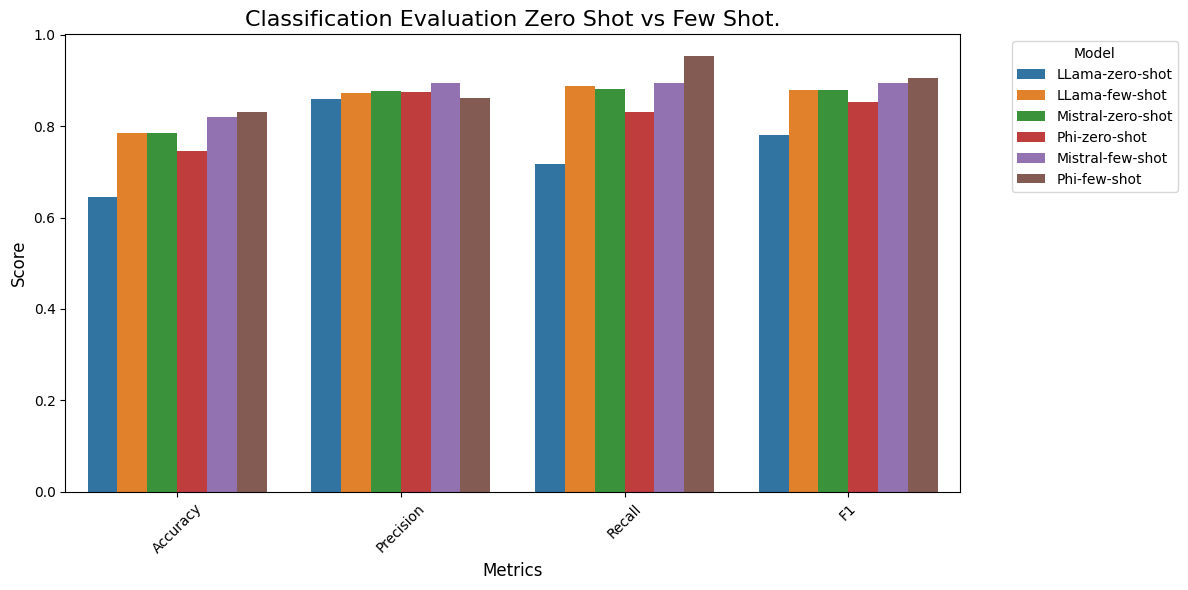

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=all_scores_df_long)

# Customize the plot
plt.title("Classification Evaluation Zero Shot vs Few Shot.", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()

In [41]:
# Convert to long-format DataFrame
zero_scores_df_long = pd.DataFrame(
    [
        {"Model": list(item.keys())[0], "Metric": metric, "Score": value}
        for item in zero_shot_metrics
        for metric, value in list(item.values())[0].items()
    ]
)
zero_scores_df_long.to_csv("zero_shot_scores.csv", index=False)
zero_scores_df_long

,Model,Metric,Score
0,Gemini-zero-shot,Accuracy,0.805000
1,Gemini-zero-shot,Precision,0.879121
2,Gemini-zero-shot,Recall,0.903955
3,Gemini-zero-shot,F1,0.891365
4,Palm-zero-shot,Accuracy,0.755000
5,Palm-zero-shot,Precision,0.880952
6,Palm-zero-shot,Recall,0.836158
7,Palm-zero-shot,F1,0.857971
8,LLama-zero-shot,Accuracy,0.645000
9,LLama-zero-shot,Precision,0.858108


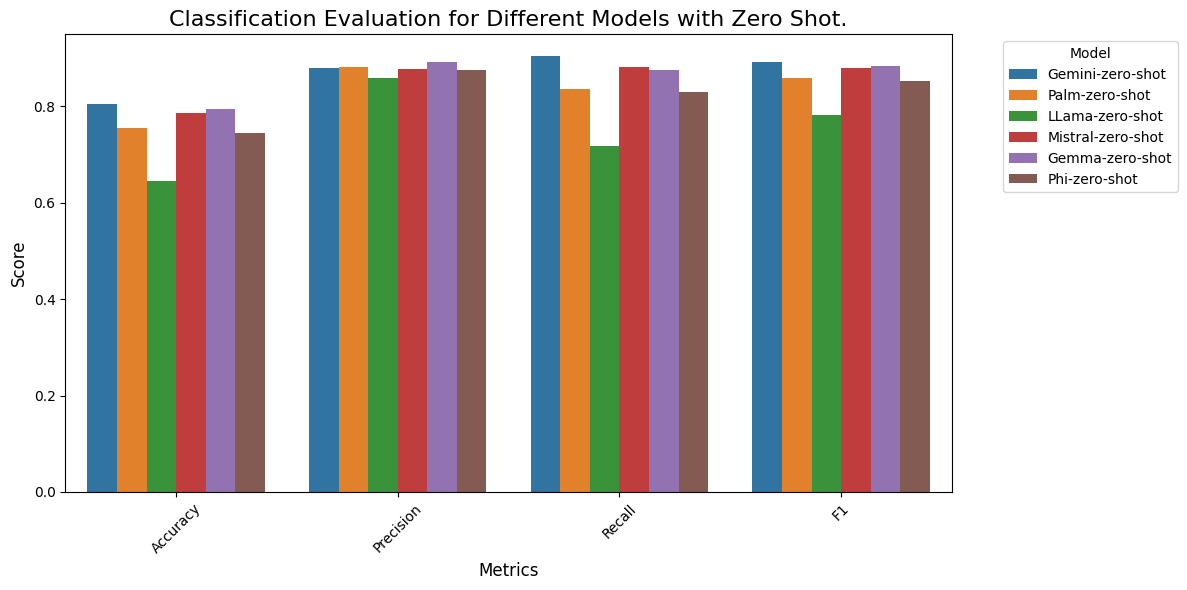

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=zero_scores_df_long)

# Customize the plot
plt.title("Classification Evaluation for Different Models with Zero Shot.", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()

In [52]:
# Convert to long-format DataFrame
few_scores_df_long = pd.DataFrame(
    [
        {"Model": list(item.keys())[0], "Metric": metric, "Score": value}
        for item in few_shot_metrics
        for metric, value in list(item.values())[0].items()
    ]
)
few_scores_df_long.to_csv("few_shot_scores.csv", index=False)
few_scores_df_long

,Model,Metric,Score
0,LLama-few-shot,Accuracy,0.785000
1,LLama-few-shot,Precision,0.872222
2,LLama-few-shot,Recall,0.887006
3,LLama-few-shot,F1,0.879552
4,Mistral-few-shot,Accuracy,0.820000
5,Mistral-few-shot,Precision,0.894118
6,Mistral-few-shot,Recall,0.894118
7,Mistral-few-shot,F1,0.894118
8,Phi-few-shot,Accuracy,0.830000
9,Phi-few-shot,Precision,0.861702


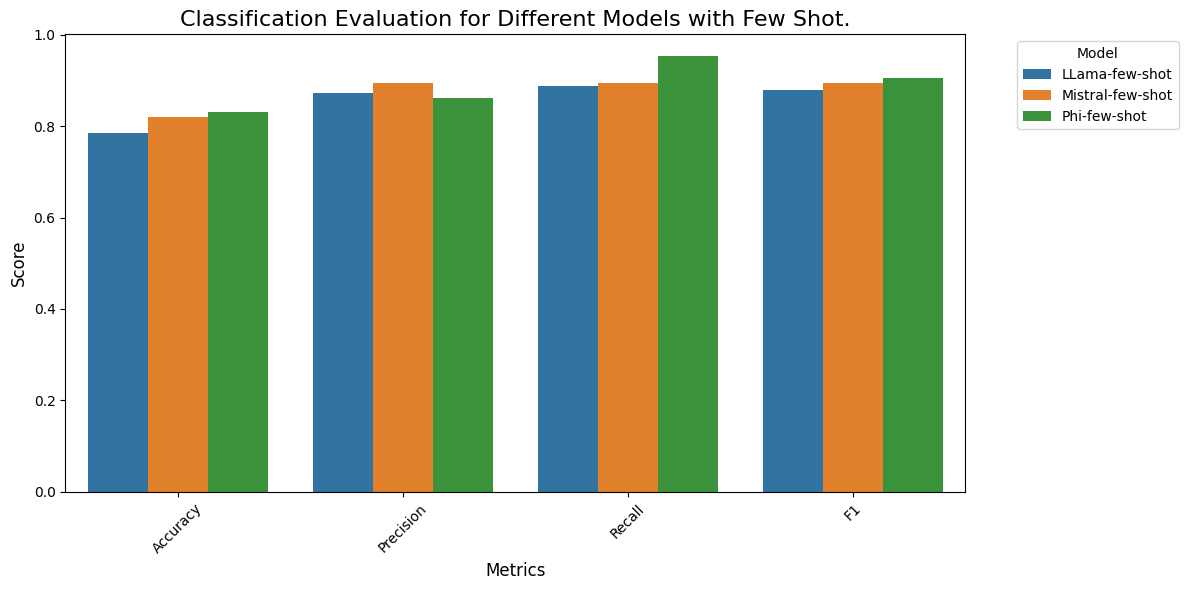

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=few_scores_df_long)

# Customize the plot
plt.title("Classification Evaluation for Different Models with Few Shot.", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()

# Fine Tuning

In [ ]:
from skllm.models.gpt.classification.tunable import GPTClassifier

clf = GPTClassifier(
    base_model="gpt-3.5-turbo-0613",
    n_epochs=None,  # int or None. When None, will be determined automatically by OpenAI
    default_label="Random",  # optional
)

clf.fit(X_llm, y_llm)  # y_train is a list of labels
labels = clf.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, labels):.2f}")